In [2]:
import numpy as np
import jax.numpy as jnp
import jax
import optax
from functools import partial 

import matplotlib.pyplot as plt

from water_balance import run_wbm
from water_balance_jax import wbm_jax

### JAX test

In [18]:
from jax import random

In [21]:
learning_rate = 0.1
def sgd(gradients, state):
    return -learning_rate * gradients, state

In [22]:
def quadratic_task(w, y, theta, opt_fn, opt_state, steps=100):
    @jax.jit
    def f(theta):
        product = jax.vmap(jnp.matmul)(w, theta)
        return jnp.mean(jnp.sum((product - y) ** 2, axis=1))

    losses = []
    for _ in range(steps):
        loss, grads = jax.value_and_grad(f)(theta)
        updates, opt_state = opt_fn(grads, opt_state)
        theta += updates
        losses.append(loss)

    return jnp.stack(losses), theta, opt_state

In [23]:
batch_size = 128
rng = random.PRNGKey(0)
keys = random.split(rng, 3)
w = random.normal(keys[0], (batch_size, 10, 10))
y = random.normal(keys[1], (batch_size, 10))
theta = random.normal(keys[2], (batch_size, 10))

In [24]:
losses, *_ = quadratic_task(w, y, theta, opt_fn=sgd, opt_state=None)

In [27]:
y.shape

(128, 10)

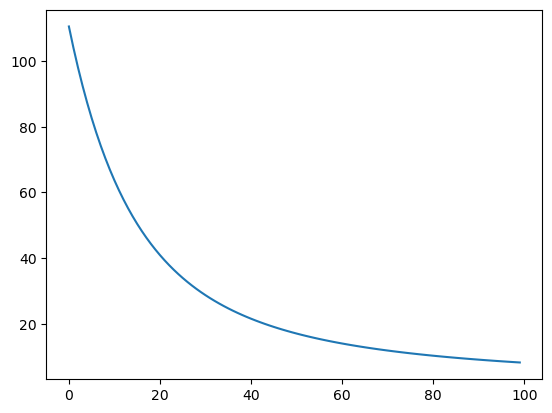

In [25]:
plt.plot(losses)

### JAX gradient descent test

In [3]:
# Simulate test data
test_in = np.load('/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/precalibration/centralUS/SMAP/inputs.npz')
test_out = np.load('/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/precalibration/centralUS/SMAP/SMAP_validation.npy')

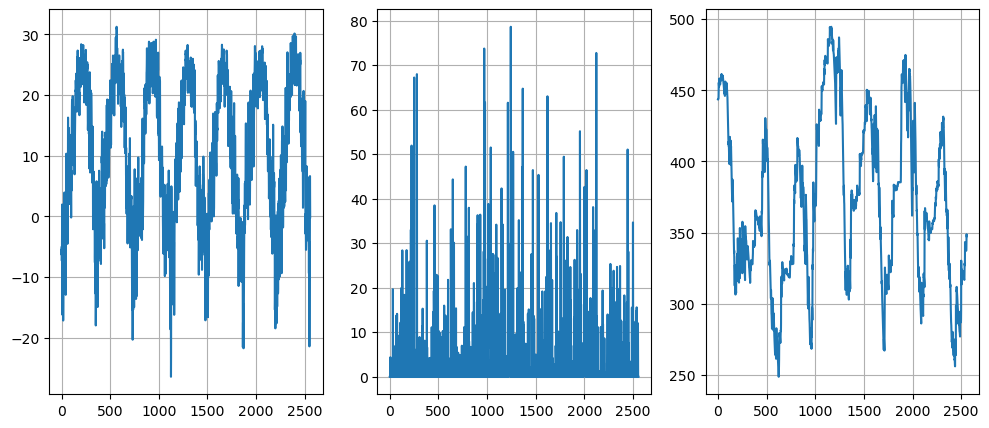

In [4]:
# Select random grid point
ix = 100
iy = 40

fig, axs = plt.subplots(1,3, figsize=(12,5))
axs[0].plot(test_in['tas'][ix,iy,:])
axs[0].grid()

axs[1].plot(test_in['prcp'][ix,iy,:])
axs[1].grid()

# Smap
axs[2].plot(test_out[ix,iy,:])
axs[2].grid()

plt.show()

In [5]:
# vmap function
wbm_jax_vmap = jax.jit(jax.vmap(wbm_jax, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, None), 0))

In [8]:
%%time
# Prepare inputs for vmap
nx = test_in['tas'].shape[0]
ny = test_in['tas'].shape[1]
nt = test_in['tas'].shape[2]

# 'forcing'
tas_in = test_in['tas'].reshape(nx * ny, nt)
prcp_in = test_in['prcp'].reshape(nx * ny, nt)

Ws_init_in = test_out[:,:,0].reshape(nx * ny)
Wi_init_in = np.zeros(nx * ny)
Sp_init_in = np.zeros(nx * ny)

clayfrac_in = test_in['clayfrac'].reshape(nx * ny)
sandfrac_in = test_in['sandfrac'].reshape(nx * ny)
siltfrac_in = test_in['siltfrac'].reshape(nx * ny)

lai_in = np.repeat(test_in['lai'].reshape(nx * ny, test_in['lai'].shape[2]), 7, axis=1)[:, :-5]

phi_in = np.tile(test_in['lats'], nx)

doy_in = test_in['doy'] + 1

# params
awCap_claycoef = jnp.log(300)
awCap_sandcoef = jnp.log(100)
awCap_siltcoef = jnp.log(400)

wiltingp_claycoef = jnp.log(50)
wiltingp_sandcoef = jnp.log(100)
wiltingp_siltcoef = jnp.log(200)

alpha_claycoef = jnp.log(1.5)
alpha_sandcoef = jnp.log(2)
alpha_siltcoef = jnp.log(3)

betaHBV_claycoef = jnp.log(1.5)
betaHBV_sandcoef = jnp.log(2.3)
betaHBV_siltcoef = jnp.log(3.4)

Kmin_claycoef = jnp.log(0.1)
Kmin_sandcoef = jnp.log(0.15)
Kmin_siltcoef = jnp.log(0.4)

Kmax_claycoef = jnp.log(0.9)
Kmax_sandcoef = jnp.log(0.5)
Kmax_siltcoef = jnp.log(0.8)

Klai_claycoef = jnp.log(0.4)
Klai_sandcoef = jnp.log(0.7)
Klai_siltcoef = jnp.log(0.6)

params_in = awCap_claycoef, awCap_sandcoef, awCap_siltcoef, \
        wiltingp_claycoef, wiltingp_sandcoef, wiltingp_siltcoef, \
        alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
        betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, \
        Kmin_claycoef, Kmin_sandcoef, Kmin_siltcoef, \
        Kmax_claycoef, Kmax_sandcoef, Kmax_siltcoef, \
        Klai_claycoef, Klai_sandcoef, Klai_siltcoef

CPU times: user 2.06 s, sys: 664 ms, total: 2.72 s
Wall time: 2.88 s


In [9]:
%%time
# run it
ys_test = wbm_jax(
    tas_in[200,:],
    prcp_in[200,:], 
    Ws_init_in[200],
    Wi_init_in[200],
    Sp_init_in[200],
    clayfrac_in[200],
    sandfrac_in[200],
    siltfrac_in[200],
    lai_in[200,:],
    phi_in[200],
    doy_in,
    params_in,
)

CPU times: user 245 ms, sys: 13.4 ms, total: 259 ms
Wall time: 275 ms


In [28]:
%%time
# run it spatial
ys = wbm_jax_vmap(
    tas_in,
    prcp_in, 
    Ws_init_in,
    Wi_init_in,
    Sp_init_in,
    clayfrac_in,
    sandfrac_in,
    siltfrac_in,
    jnp.nan_to_num(lai_in, nan=0.2),
    phi_in,
    doy_in,
    params_in,
)

CPU times: user 9.29 s, sys: 467 ms, total: 9.76 s
Wall time: 9.85 s


In [29]:
x_forcing = jnp.stack([tas_in, prcp_in, jnp.nan_to_num(lai_in, nan=0.2)], axis=1)
# NaN inds
nan_inds = jnp.isnan(x_forcing).any(axis=(1,2))
x_forcing = x_forcing[~nan_inds]

x_maps = jnp.stack([Ws_init_in, Wi_init_in, Sp_init_in, clayfrac_in, sandfrac_in, siltfrac_in, phi_in], axis=1)
x_maps = x_maps[~nan_inds]

x_const = doy_in

ys_nnan = ys[~nan_inds]
# ys_nnan = jnp.nan_to_num(ys_nnan, nan=300.)

In [31]:
def loss_fn(theta, x_forcing, x_maps, x_const, y):
    # Must be correct order!
    tas, prcp, lai = x_forcing
    Ws_init, Wi_init, Sp_init, clayfrac, sandfrac, siltfrac, phi = x_maps
    doy = x_const

    # Make prediction
    prediction = wbm_jax(
        tas,
        prcp, 
        Ws_init,
        Wi_init,
        Sp_init,
        clayfrac,
        sandfrac,
        siltfrac,
        lai,
        phi,
        doy,
        theta
    )
    # Return RMSE 
    return jnp.nanmean((prediction-y)**2)

In [32]:
theta_true = jnp.array([awCap_claycoef, awCap_sandcoef, awCap_siltcoef, \
                  wiltingp_claycoef, wiltingp_sandcoef, wiltingp_siltcoef, \
                  alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
                  betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, \
                  Kmin_claycoef, Kmin_sandcoef, Kmin_siltcoef, \
                  Kmax_claycoef, Kmax_sandcoef, Kmax_siltcoef, \
                  Klai_claycoef, Klai_sandcoef, Klai_siltcoef])

In [33]:
loss_grad = jax.jit(jax.vmap(jax.grad(loss_fn), in_axes=(None, 0, 0, None, 0), out_axes=0))
loss_value_and_grad = jax.jit(jax.vmap(jax.value_and_grad(loss_fn), in_axes=(None, 0, 0, None, 0), out_axes=0))

In [37]:
%%time

# Define mini-batch hyper-parameters
N = x_forcing.shape[0]
batch_size = 2**7
n_minibatches = N // batch_size

# Initial parameters
theta = jnp.array([5., 5., 5., 5., 5., 5., 1., 1., 1., 1., 1., 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])
# theta = theta_true * 0.99

# Optimizer
adam = optax.adam(learning_rate=1e-2)
opt_fn = adam.update
opt_state = adam.init(theta)

# adagrad = optax.adagrad(learning_rate = 0.01)
# opt_fn = adagrad.update
# opt_state = adagrad.init(theta)

# SGD optimizers
# learning_rate = 1e-5
# opt_state = None
# def sgd(gradients, state):
#     return -learning_rate * gradients, state
# opt_fn = sgd

# Epochs
n_epochs = 50

# Loss
loss_out = np.empty(n_epochs)

for epoch in range(n_epochs):
    # Shuffle indices
    shuffled_inds = np.random.permutation(N)
    
    # Generate a mini-batch
    minibatch_inds = [shuffled_inds[(i*batch_size):((i + 1)*batch_size)] for i in range(n_minibatches + 1)]

    for inds in minibatch_inds:
        x_forcing_batch = x_forcing[inds]
        x_map_batch = x_maps[inds]
        ys_batch = ys_nnan[inds]
    
        # Calculate gradient of loss function, update parameters
        loss, grads = loss_value_and_grad(theta, x_forcing_batch, x_map_batch, x_const, ys_batch)
        updates, opt_state = opt_fn(jnp.mean(grads, axis=0), opt_state)
        theta = optax.apply_updates(theta, updates)

    # Store loss
    loss_out[epoch] = jnp.mean(loss)
    if epoch % 5 == 0:
        print(f"Epoch {str(epoch)}, loss: {loss_out[epoch]:.2f}")
    if jnp.sum(jnp.isnan(loss)):
        break

Epoch 0, loss: 258.13
Epoch 5, loss: 23.96
Epoch 10, loss: 6.59
Epoch 15, loss: 2.85
Epoch 20, loss: 0.84
Epoch 25, loss: 0.60
Epoch 30, loss: 0.52
Epoch 35, loss: 0.70
Epoch 40, loss: 0.28
Epoch 45, loss: 0.33
CPU times: user 22min 9s, sys: 1min 42s, total: 23min 51s
Wall time: 23min 58s


In [43]:
loss_out[-1]

0.3281167447566986

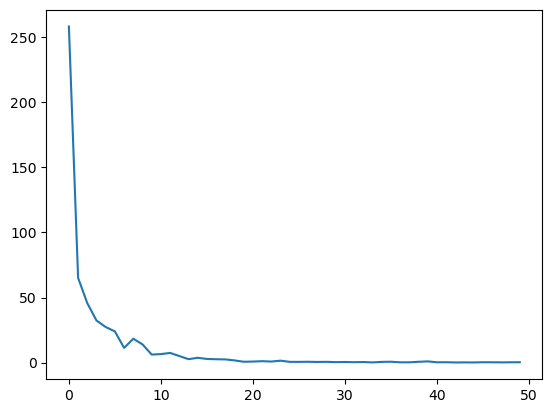

In [38]:
plt.plot(loss_out)

In [39]:
theta

Array([ 5.5433235 ,  4.622177  ,  6.048987  ,  4.530253  ,  4.5883636 ,
        5.177001  ,  0.88099766,  0.66100144,  0.9315611 ,  0.17450093,
        0.83914435,  1.2699289 , -2.191114  , -1.9025475 , -0.9323914 ,
       -0.08526453, -0.6980726 , -0.23475999, -1.0008633 , -0.34439555,
       -0.48598126], dtype=float32)

In [40]:
jnp.mean(grads, axis=0)

Array([ -6.8912773 ,  -3.3981314 , -20.062582  ,  -1.1122538 ,
        -3.5626898 ,  -7.997406  ,   0.27710205,   0.19646175,
         0.4115129 ,  -0.50557506,  -0.94491917,  -2.5392225 ,
         0.3686115 ,   0.47847277,   1.7803991 ,   3.3716505 ,
         1.8215415 ,   4.6750083 ,   0.68970376,   1.0926725 ,
         1.6618509 ], dtype=float32)

In [41]:
theta_true

Array([ 5.7037826 ,  4.6051702 ,  5.9914646 ,  3.912023  ,  4.6051702 ,
        5.2983174 ,  0.4054651 ,  0.6931472 ,  1.0986123 ,  0.4054651 ,
        0.8329091 ,  1.2237755 , -2.3025851 , -1.89712   , -0.9162907 ,
       -0.10536055, -0.6931472 , -0.22314353, -0.9162907 , -0.35667497,
       -0.5108256 ], dtype=float32)

In [42]:
theta - theta_true

Array([-0.16045904,  0.01700687,  0.0575223 ,  0.61822987, -0.0168066 ,
       -0.12131643,  0.47553256, -0.03214574, -0.1670512 , -0.23096417,
        0.00623524,  0.04615343,  0.11147118, -0.00542748, -0.0161007 ,
        0.02009601, -0.00492543, -0.01161645, -0.08457261,  0.01227942,
        0.02484432], dtype=float32)

### WBM

In [4]:
######################
# Select state
name = 'illinois'
######################

T = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_temperature.txt")
P = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_precip.txt")
lai = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_lai.txt")
soilMoist = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_soilMoist.txt")[0]
soilMoistFrac = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_soilMoistFrac.txt")
Kc = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_kc.txt")

# Select correct latitiude
# SD: [44,-98]
# IA: [42,-93]
# IL: [40,-89]
lat_dict = {"southdakota":44., "iowa":42., "illinois":40.}
lat = lat_dict[name]

################
# Inputs
################
phi = lat          # Latitude
Ws_init = soilMoist  # Initial soil moisture: take from WBM
Wi_init = 0.5           # Canopy water storage
Sp_init = 0.             # Snowpack

# Make dicts
initial_conditions = {}
initial_conditions["Ws_init"] = Ws_init
initial_conditions["Wi_init"] = Wi_init
initial_conditions["Sp_init"] = Sp_init

forcing_data = {}
forcing_data["prcp"] = P
forcing_data["tas"] = T

X = np.loadtxt('/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/param_values.txt', float)
iparam = 1000
parameters = {}
parameters["Ts"] = X[iparam][0]
parameters["Tm"] = X[iparam][1]
parameters['Clai'] = X[iparam][2]
parameters["awCap"] = X[iparam][3]
parameters["wiltingp"] = X[iparam][4]
parameters["alpha"] = X[iparam][5]
parameters["betaHBV"] = X[iparam][6]
parameters["Kmin"] = X[iparam][7]
parameters["Kmax"] = X[iparam][8]
parameters["Klai"] = X[iparam][9]

constants = {}
constants["lai"] = lai
constants["phi"] = phi
constants["nt"] = len(T)-1
constants["doy"] = np.arange(1,len(T)+1)
constants["rootDepth"] = 1000.

# run
out = wbm(
    initial_conditions=initial_conditions,
    forcing_data=forcing_data,
    parameters=[parameters[key] for key in parameters.keys()],
    constants=constants,
)

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [ ]:
plt.plot(out)

In [5]:
def loss_fn(params, y):
  prediction = wbm(
      initial_conditions=initial_conditions,
      forcing_data=forcing_data,
      parameters=params,
      constants=constants,
  )

    
  return jnp.mean((prediction-y)**2)

In [ ]:
params = jnp.array([parameters[key] for key in parameters.keys()])

In [ ]:
jax.grad(loss_fn)(params, out)

In [123]:
@jax.jit
def update(params, Ws_out, lr=0.0001):
  return params - lr * jax.grad(loss_fn)(params, Ws_out)

In [124]:
params = jnp.array([100., 100., 1., 1.])

In [125]:
jax.grad(loss_fn)(params, Ws_out)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float32[1,1].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [53]:
params = jnp.array([100., 100., 1., 1.])

for _ in range(1000):
  params = update(params, Ws_out)

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 0.